Montar drive para ler ficheiro da sales

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install ydata_profiling
! pip install plotly
! pip install fuzzywuzzy

In [3]:
# libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import plot
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Suppress warnings to enhance code readability
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



#Data Profiling

In [4]:
# read datasets
sales = pd.read_csv('/content/drive/Shareddrives/Projeto II/CSV_raw/sales.csv')
product = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTLVeXZeo0CrX_IoDUEgASMnqqfxSMLpt_tB_7dxOWRzXrYBJVKUEpA_lUmA2JrGw/pub?output=csv')
cities = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQVzyKZ9KHcOfW0uZwqUszAdI-opC72lYEAtpJBZxwuWTuvc_h18SIaCAgwvxXfHt2ixlraZCcs0Lrl/pub?output=csv')
fore_rev = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQcchFjMPX1jweLzxW74vmshHbw0afm3VKEPffmsZCtHmduzWTcrO9T6HVLKJVXUw/pub?output=csv')

In [5]:
#create a function to find outliers using IQR

def find_outliers_iqr(dataframe, column_name):

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)

    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = dataframe[(dataframe[column_name] < lower_bound) | (dataframe[column_name] > upper_bound)][column_name]

    return outliers

##Cities

In [6]:
#profile_cities = ProfileReport(cities, title="Cities Profiling Report")
#profile_cities
#profile_cities.to_file("Cities Profiling Report.html")

###Outliers
Numerical variable

<Axes: >

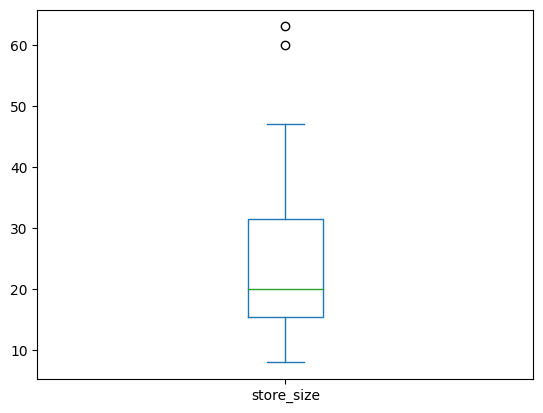

In [7]:
#In the profiling file, it was possible to see outliers in the histogram.
#However, the box plot was used to get a different view of the variable.
cities.store_size.plot(kind='box')

As seen, there are outliers (60 and 63)







In [8]:
# outliers for store_size

outliers = find_outliers_iqr(cities, 'store_size')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 2
max outlier value: 63
min outlier value: 60


5     63
39    60
Name: store_size, dtype: int64

###Cities names
To see encoding issues

In [9]:
cities['city_code'].unique()


array(['Denizli', 'Ankara', '?zmir', 'Bursa', 'Antalya', 'Konya', 'Adana',
       'Sanl?urfa', 'Gaziantep', 'Mersin', 'Diyarbak?r', 'Kayseri',
       'Samsun', 'Istanbul', 'Eski?ehir', 'Adapazar?', 'Kahramanmaras',
       'Erzurum', 'Van'], dtype=object)

##Sales

In [10]:
#profile_sales = ProfileReport(sales, title="Sales Profiling Report")
#profile_sales
#profile_sales.to_file("Sales Profiling Report.html")

###Outliers for numerical variables

In [11]:
sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886058 entries, 0 to 8886057
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   store_id               object 
 2   product_id             object 
 3   date                   object 
 4   sales                  float64
 5   revenue                float64
 6   stock                  float64
 7   price                  float64
 8   promo_type_1           object 
 9   promo_bin_1            object 
 10  promo_type_2           object 
 11  promo_bin_2            object 
 12  promo_discount_2       float64
 13  promo_discount_type_2  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 949.1+ MB


<Axes: >

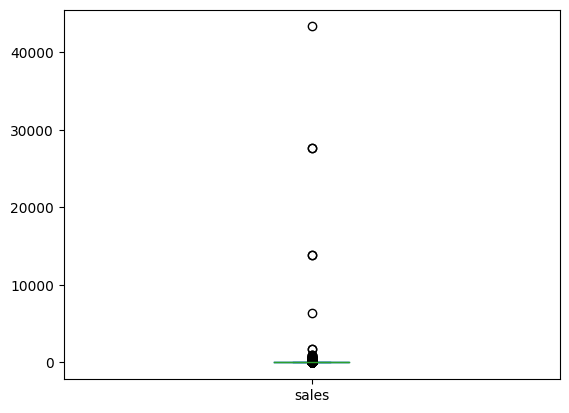

In [12]:
# boxplot for sales

sales.sales.plot(kind='box')

In [13]:
# ouliers for sales

outliers = find_outliers_iqr(sales, 'sales')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 1534855
max outlier value: 43301.0
min outlier value: 0.018


3          1.0
5          1.0
7          2.0
9          7.0
15         1.0
          ... 
8583727    3.0
8583732    1.0
8583738    3.0
8583741    2.0
8583753    1.0
Name: sales, Length: 1534855, dtype: float64

Check if there are float numbers in sales

In [14]:
# Function to check if a value is a float
def is_float(value):
    try:
        float_value = float(value)
        return '.' in str(value)
    except ValueError:
        return False

# Check if the column contains any float numbers
float_exists = sales['sales'].apply(is_float).any()

print("Does the column contain float numbers?", float_exists)

Does the column contain float numbers? True


Sales column that contain decimal numbers.

In [15]:
# Filtering out non-finite values
float_sales = sales['sales'].dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Filtering stores with float numbers in sales
float_sales = sales[sales['sales'].isin(float_sales[float_sales != float_sales.astype(int)])]

# Display the stores
print(float_sales['store_id'].unique())
print(float_sales['store_id'].nunique())
#display the products
print(float_sales['product_id'].unique())
print(float_sales['product_id'].nunique())

['S0002' 'S0003' 'S0005' 'S0010' 'S0012' 'S0014' 'S0015' 'S0016' 'S0020'
 'S0022' 'S0023' 'S0026' 'S0032' 'S0036' 'S0038' 'S0039' 'S0040' 'S0045'
 'S0046' 'S0050' 'S0052' 'S0055' 'S0056' 'S0058' 'S0059' 'S0061' 'S0062'
 'S0067' 'S0068' 'S0071' 'S0072' 'S0073' 'S0080' 'S0083' 'S0085' 'S0086'
 'S0088' 'S0089' 'S0091' 'S0092' 'S0094' 'S0095' 'S0097' 'S0099' 'S0102'
 'S0104' 'S0107' 'S0108' 'S0109' 'S0120' 'S0122' 'S0126' 'S0131' 'S0132'
 'S0136' 'S0142' 'S0143']
57
['P0413' 'P0561' 'P0316' 'P0176' 'P0610' 'P0630' 'P0550' 'P0725' 'P0031'
 'P0155' 'P0484']
11


57/63 stores have decimal numbers in sales: ['S0002' 'S0003' 'S0005' 'S0010' 'S0012' 'S0014' 'S0015' 'S0016' 'S0020'
 'S0022' 'S0023' 'S0026' 'S0032' 'S0036' 'S0038' 'S0039' 'S0040' 'S0045'
 'S0046' 'S0050' 'S0052' 'S0055' 'S0056' 'S0058' 'S0059' 'S0061' 'S0062'
 'S0067' 'S0068' 'S0071' 'S0072' 'S0073' 'S0080' 'S0083' 'S0085' 'S0086'
 'S0088' 'S0089' 'S0091' 'S0092' 'S0094' 'S0095' 'S0097' 'S0099' 'S0102'
 'S0104' 'S0107' 'S0108' 'S0109' 'S0120' 'S0122' 'S0126' 'S0131' 'S0132'
 'S0136' 'S0142' 'S0143']

 11/615 products have decimal numbers in sales: ['P0413' 'P0561' 'P0316' 'P0176' 'P0610' 'P0630' 'P0550' 'P0725' 'P0031'
 'P0155' 'P0484']

In [16]:
# Reset index
float_sales = float_sales.reset_index(drop=True)
# Select store_id and product_id columns from filtered DataFrame
float_sales = float_sales[['store_id', 'product_id']]
float_sales

,store_id,product_id
0,S0002,P0413
1,S0002,P0413
2,S0002,P0413
3,S0002,P0413
4,S0002,P0413
...,...,...
17207,S0143,P0413
17208,S0143,P0413
17209,S0143,P0413
17210,S0143,P0413


In [17]:
filter_table = pd.DataFrame(float_sales)

# Merge final_table with cities on store_id to get storetype_id
merged_data = pd.merge(filter_table, cities, on='store_id', how='left')

# Drop duplicate store_id rows (if any) after merge
merged_data = merged_data.drop_duplicates(subset=['store_id', 'storetype_id'])

# Display the result
filtered_data = merged_data.filter(['store_id', 'storetype_id'])
print(filtered_data['storetype_id'].unique())

['ST04' 'ST03' 'ST01' 'ST02']


all store types have sales with decimal numbers

<Axes: >

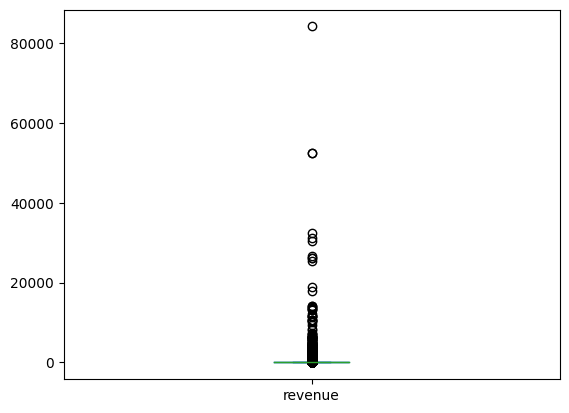

In [18]:
# boxplot for revenue
sales.revenue.plot(kind='box')


In [19]:
# ouliers for revenue

outliers = find_outliers_iqr(sales, 'revenue')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 1533783
max outlier value: 84197.961
min outlier value: 0.01


3           2.41
5           1.81
7           4.54
9           4.54
15          5.79
           ...  
8583727     4.50
8583732     4.40
8583738    22.22
8583741     8.80
8583753     5.51
Name: revenue, Length: 1533783, dtype: float64

<Axes: >

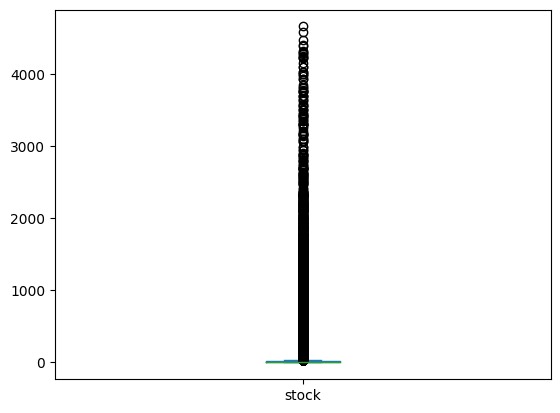

In [20]:
# boxplot for stock
sales.stock.plot(kind='box')


In [21]:
# ouliers for stock
outliers = find_outliers_iqr(sales, 'stock')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 674701
max outlier value: 4655.0
min outlier value: 36.525


5           37.0
9          132.0
16          55.0
22          46.0
27          58.0
           ...  
8583474     44.0
8583543     44.0
8583610     44.0
8583677     44.0
8583747     44.0
Name: stock, Length: 674701, dtype: float64

<Axes: >

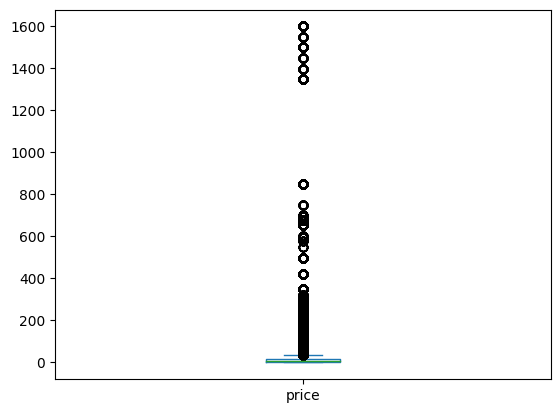

In [22]:
#boxplot for price
sales.price.plot(kind='box')


In [23]:
# ouliers for price

outliers = find_outliers_iqr(sales, 'price')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 747066
max outlier value: 1599.0
min outlier value: 37.25


2           49.9
21          99.9
52          59.9
58          59.9
88          53.9
           ...  
8885982     41.5
8885986    139.9
8886000     89.9
8886050     41.5
8886054    139.9
Name: price, Length: 747066, dtype: float64

<Axes: >

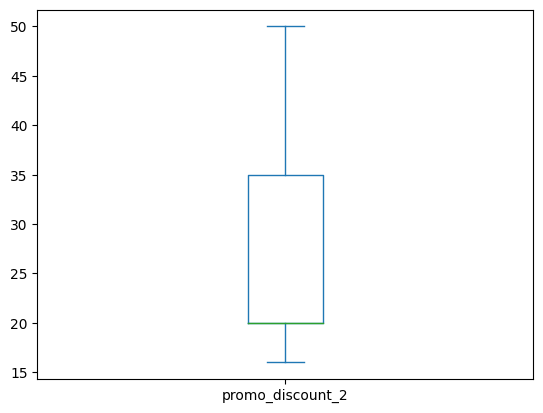

In [24]:
# boxplot for promo_discount_2

sales.promo_discount_2.plot(kind='box')

In [25]:
# ouliers for promo_discount_2

outliers = find_outliers_iqr(sales, 'sales')

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

outliers

number of outliers: 1534855
max outlier value: 43301.0
min outlier value: 0.018


3          1.0
5          1.0
7          2.0
9          7.0
15         1.0
          ... 
8583727    3.0
8583732    1.0
8583738    3.0
8583741    2.0
8583753    1.0
Name: sales, Length: 1534855, dtype: float64

###Sales per year
Comparison between months and years

In [26]:
# Convert 'date' column to datetime format
sales['date'] = pd.to_datetime(sales['date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886058 entries, 0 to 8886057
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   store_id               object        
 2   product_id             object        
 3   date                   datetime64[ns]
 4   sales                  float64       
 5   revenue                float64       
 6   stock                  float64       
 7   price                  float64       
 8   promo_type_1           object        
 9   promo_bin_1            object        
 10  promo_type_2           object        
 11  promo_bin_2            object        
 12  promo_discount_2       float64       
 13  promo_discount_type_2  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(7)
memory usage: 949.1+ MB


In [27]:
# Extract year and month
sales['Year'] = sales['date'].dt.year
sales['Month'] = sales['date'].dt.strftime('%b')


In [28]:
# Separate DataFrames for each year
df_2017 = sales[sales['Year'] == 2017]
df_2018 = sales[sales['Year'] == 2018]
df_2019 = sales[sales['Year'] == 2019]


In [29]:
# Group by month for each year
grouped_2017 = df_2017.groupby(df_2017['date'].dt.month)['sales'].sum()
grouped_2018 = df_2018.groupby(df_2018['date'].dt.month)['sales'].sum()
grouped_2019 = df_2019.groupby(df_2019['date'].dt.month)['sales'].sum()

#### Plotting the data

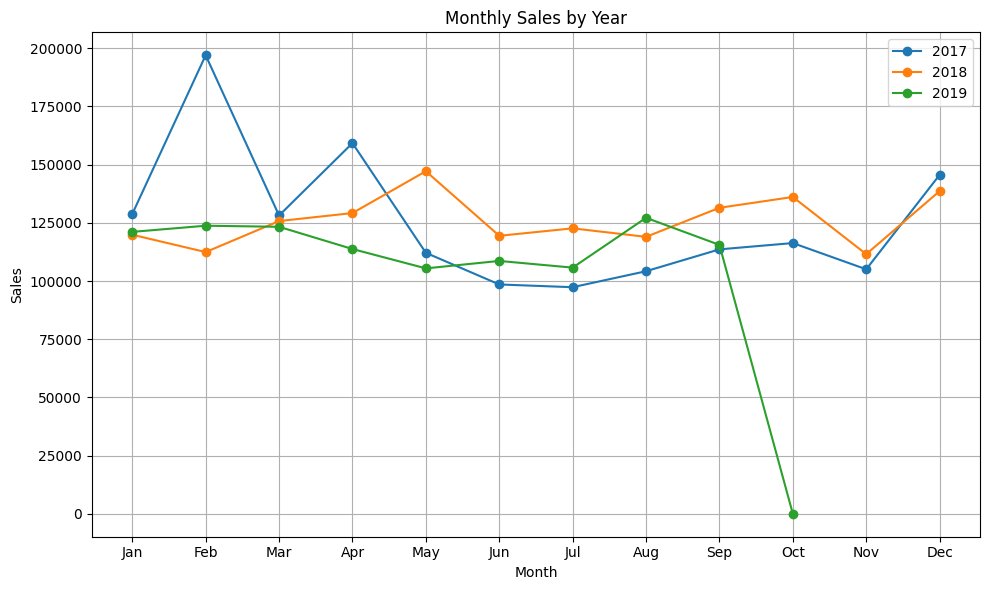

In [30]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(grouped_2017.index, grouped_2017.values, marker='o', linestyle='-', label='2017')
plt.plot(grouped_2018.index, grouped_2018.values, marker='o', linestyle='-', label='2018')
plt.plot(grouped_2019.index, grouped_2019.values, marker='o', linestyle='-', label='2019')

plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Avg Sales By Day, Week, Month and Day Of Week


In [31]:
# set date as index
df = sales.copy()
df.set_index('date', inplace = True)
# Ensure the DataFrame is sorted by date
df.sort_index(inplace=True)
# confirm index
df.head()

,Unnamed: 0,store_id,product_id,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2,Year,Month
date,,,,,,,,,,,,,,,
2017-01-02,1,S0002,P0001,0.000,0.00,8.00,6.25,PR14,NaN,PR03,NaN,NaN,NaN,2017,Jan
2017-01-02,374614,S0010,P0413,12.175,55.80,16.29,2.99,PR14,NaN,PR03,NaN,NaN,NaN,2017,Jan
2017-01-02,374615,S0010,P0425,0.000,0.00,4.00,4.50,PR14,NaN,PR03,NaN,NaN,NaN,2017,Jan
2017-01-02,374616,S0010,P0427,0.000,0.00,12.00,2.45,PR06,low,PR03,NaN,NaN,NaN,2017,Jan
2017-01-02,374617,S0010,P0435,1.000,21.61,6.00,25.50,PR14,NaN,PR03,NaN,NaN,NaN,2017,Jan


In [32]:
# return only sales >0
df = df[df['sales'] > 0]


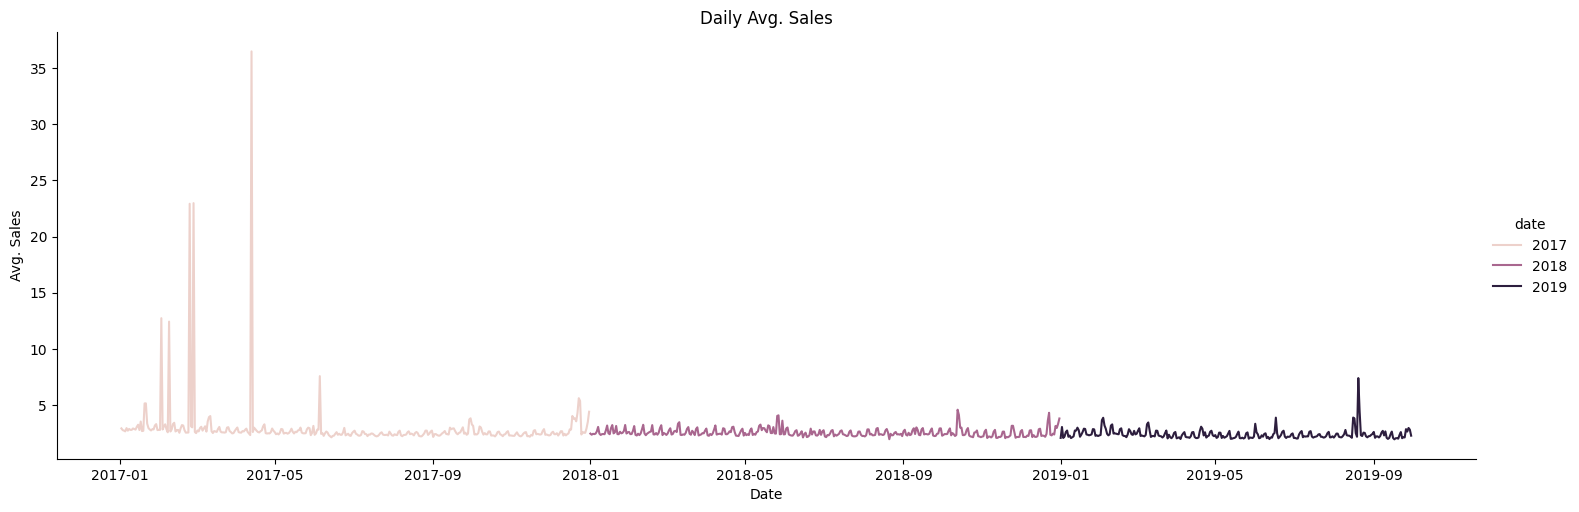

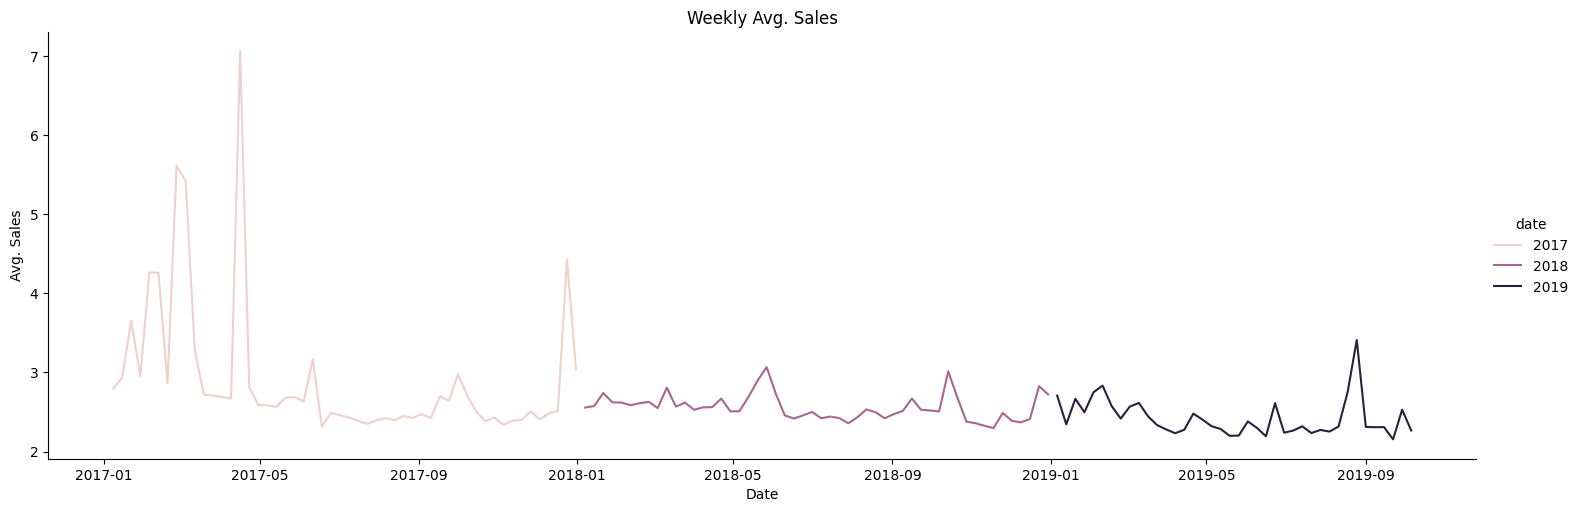

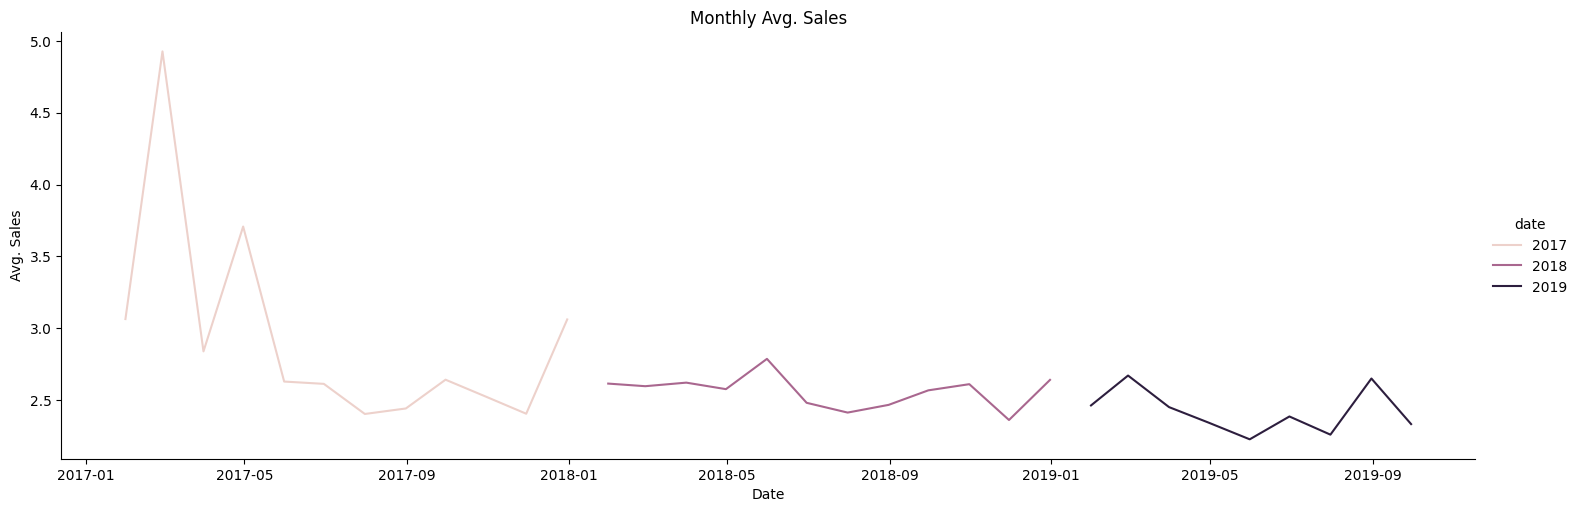

In [33]:
# plot average  sales

daily_sales=df.resample('D').sales.mean().to_frame()  # Resample sales by day
weekly_sales=df.resample('W').sales.mean().to_frame()  # Resample sales by week
monthly_sales=df.resample('M').sales.mean().to_frame()  # Resample sales by month

df_list=[daily_sales,weekly_sales,monthly_sales]
titles=['Daily Avg. Sales','Weekly Avg. Sales','Monthly Avg. Sales']

for i,j in zip(df_list,titles):

    sns.relplot(x=i.index,y=i.sales,kind='line',aspect=3,hue=i.index.year)
    plt.xlabel('Date')
    plt.ylabel('Avg. Sales')
    plt.title(j)

Total sales over time

###October 2019
Based on the previous analysis, was possible to see sales of October 2019 = 0.


In [34]:
sales_oct=df_2019[df_2019['Month']== 'Oct']
print(sales_oct.shape)
print(sales_oct.isnull().sum())

(302296, 16)
Unnamed: 0                    0
store_id                      0
product_id                    0
date                          0
sales                    302296
revenue                  302296
stock                    302296
price                      1972
promo_type_1                  0
promo_bin_1              251772
promo_type_2                  0
promo_bin_2              298058
promo_discount_2         298058
promo_discount_type_2    298058
Year                          0
Month                         0
dtype: int64


There are no records in revenue, sales and stock variables on October 2019.

### Sales per store

In [35]:
# Filter the sales DataFrame to include only positive sales
filtered_sales = sales[sales['sales'] > 0]

df_sales_store = filtered_sales.groupby(['store_id', 'Year']).size().reset_index(name='count')

# Pivot the DataFrame
df_sales_store_p = df_sales_store.pivot(index='store_id', columns='Year', values='count').reset_index()
df_sales_store_p.columns.name = None


# Add a new column for the sum of each store across all years
df_sales_store_p['total'] = df_sales_store.sum(axis=1, numeric_only=True)
df_sales_store_p

,store_id,2017,2018,2019,total
0,S0002,12832.0,13590.0,9525.0,14849
1,S0003,5832.0,6036.0,4239.0,15608
2,S0005,NaN,5254.0,3868.0,11544
3,S0007,NaN,NaN,2591.0,7849
4,S0010,12060.0,11886.0,7872.0,8054
...,...,...,...,...,...
58,S0132,10640.0,11566.0,8502.0,6157
59,S0136,840.0,1364.0,1164.0,7033
60,S0141,3815.0,3812.0,2252.0,6252
61,S0142,7231.0,8167.0,5367.0,10241


In [36]:
# Melt the DataFrame to long format for use with plotly
df_long = pd.melt(df_sales_store_p, id_vars=['store_id'], value_vars=[2017, 2018, 2019],
                  var_name='Year', value_name='count').dropna()
# Create the plot using plotly.express

fig = px.bar(df_long, x='store_id', y='count', color='Year',
             title='Sales Count per Store by Year',
             labels={'store_id': 'Store ID', 'count': 'Sales Count'})

# Update layout for better readability
fig.update_layout(xaxis=dict(tickangle=45))

# Display the plot
fig.show()

S0085 seems to have more sells, followed by S0062 and S0026
Some stores do not show data for 2017 sales -> only opened after? (S0005, S0036, S0046, S0061, S0071, S0076, S0092, S0109)
S0007 only shows values for 2019 -> only opened in 2019?

# Revenue per store

In [37]:
# Group by store_id and Year, then sum the revenue
df_revenue_store = filtered_sales.groupby(['store_id', 'Year'])['revenue'].sum().reset_index()

# Pivot the DataFrame
df_revenue_store_p = df_revenue_store.pivot(index='store_id', columns='Year', values='revenue').reset_index()
df_revenue_store_p.columns.name = None

# Add a new column for the sum of revenue for each store across all years
df_revenue_store_p['total_rev'] = df_revenue_store_p.sum(axis=1, numeric_only=True)
df_revenue_store_p

,store_id,2017,2018,2019,total_rev
0,S0002,125121.21,175934.93,173764.53,474820.67
1,S0003,32671.81,45476.80,48837.80,126986.41
2,S0005,NaN,52677.04,49383.51,102060.55
3,S0007,NaN,NaN,21828.81,21828.81
4,S0010,107462.65,128455.10,111551.65,347469.40
...,...,...,...,...,...
58,S0132,77662.74,109195.17,119892.39,306750.30
59,S0136,4932.36,9363.40,13311.78,27607.54
60,S0141,14213.18,18244.17,13844.22,46301.57
61,S0142,55382.22,72840.57,70297.45,198520.24


In [38]:
# vizualization of results

# Melt the DataFrame to have a long format for easier plotting
df_melted = df_revenue_store_p.melt(id_vars=['store_id', 'total_rev'], var_name='Year', value_name='revenue')

# Create a figure
fig = go.Figure()

# Add bar traces for each year
years = df_melted['Year'].unique()
for year in years:
    df_year = df_melted[df_melted['Year'] == year]
    fig.add_trace(go.Bar(x=df_year['store_id'], y=df_year['revenue'], name=f'{year}'))

# Add a line trace for total revenue per store
fig.add_trace(go.Scatter(
    x=df_revenue_store_p['store_id'],
    y=df_revenue_store_p['total_rev'],
    mode='lines+markers',
    name='Total Revenue',
    line=dict(color='black', dash='dash')
))

# Update layout
fig.update_layout(
    title='Revenue per Store per Year',
    xaxis_title='Store ID',
    yaxis_title='Revenue',
    barmode='group'
)

# Show the plot
fig.show()

S0085 has the higher revenue, followed by S0097, S0026 and S0062.

In general, 2017 was the year which had more revenue.



# Revenue and sales per city


In [39]:
# Incorrectly encoded city codes
incorrect_city_names = cities.city_code

# List of correct city codes
correct_city_names = ['Istanbul', 'Antalya', 'Sanliurfa', 'Konya', 'Izmir',
                    'Samsun', 'Kahramanmaras', 'Van', 'Denizli', 'Erzurum',
                    'Adana', 'Gaziantep', 'Diyarbakir', 'Kayseri', 'Bursa',
                    'Mersin', 'Ankara', 'Adapazari', 'Eskisehir']

# Function to find the best match for the incorrect code in the list of correct codes
def correct_city_name(incorrect_name, correct_names):
    best_match = process.extractOne(incorrect_name, correct_names, scorer=fuzz.ratio)
    return best_match[0] if best_match else incorrect_name

# Replace incorrect city code with correct ones
corrected_city_names = [correct_city_name(name, correct_city_names) for name in incorrect_city_names]

# Print unique correct city code
set(corrected_city_names)

cities = cities.assign(city_code=corrected_city_names)


# join city from cities dataset
df_city = pd.merge(filtered_sales, cities[['city_code', 'store_id']], on = 'store_id', how='left')

df_filter_rev = df_city.groupby(['city_code', 'Year'])['revenue'].sum().reset_index()
# Pivot the DataFrame so that 'Year' values become columns
df_pivot_rev = df_filter_rev.pivot(index='city_code', columns='Year', values='revenue').reset_index()

# Calculate the 'total' column as sum of revenues across all years
df_pivot_rev['total_rev'] = df_pivot_rev.sum(axis=1, numeric_only=True)

# Print the final DataFrame
df_pivot_rev

Year,city_code,2017,2018,2019,total_rev
0,Adana,125121.210,175934.93,173764.53,4.748207e+05
1,Adapazari,110152.180,155844.15,161513.55,4.275099e+05
2,Ankara,158689.600,227126.90,263901.72,6.497182e+05
3,Antalya,69868.240,131116.57,196383.41,3.973682e+05
4,Bursa,257810.910,381439.31,352328.63,9.915788e+05
5,Denizli,NaN,104219.03,105318.61,2.095376e+05
6,Diyarbakir,77662.740,109195.17,119892.39,3.067503e+05
7,Erzurum,77232.950,95189.53,71230.86,2.436533e+05
8,Eskisehir,143519.530,202655.12,202648.38,5.488230e+05
9,Gaziantep,35020.000,42506.69,47094.96,1.246216e+05


In [40]:
# Create the plotly figure
fig = go.Figure()

# Add bar traces for each year
for year in df_pivot_rev.columns[1:-1]:  # Exclude 'city_code' and 'total' columns
    fig.add_trace(go.Bar(
        x=df_pivot_rev['city_code'],
        y=df_pivot_rev[year],
        name=str(year)
    ))

# Add a line trace for the total revenue
fig.add_trace(go.Scatter(
    x=df_pivot_rev['city_code'],
    y=df_pivot_rev['total_rev'],
    mode='lines+markers',
    name='Total'
))

# Update layout
fig.update_layout(
    title='Revenue per City per Year',
    xaxis_title='City Code',
    yaxis_title='Revenue',
    barmode='group'
)

In [41]:
df_filter_s = df_city.groupby(['city_code', 'Year'])['sales'].sum().reset_index()
# Pivot the DataFrame so that 'Year' values become columns
df_pivot_s = df_filter_s.pivot(index='city_code', columns='Year', values='sales').reset_index()

# Calculate the 'total' column as sum of revenues across all years
df_pivot_s['total_sales'] = df_pivot_s.sum(axis=1, numeric_only=True)

# Print the final DataFrame
df_pivot_s

Year,city_code,2017,2018,2019,total_sales
0,Adana,37411.430,37387.370,26793.500,101592.300
1,Adapazari,26298.750,27843.205,19588.190,73730.145
2,Ankara,46923.002,47336.465,35587.640,129847.107
3,Antalya,26723.350,35689.440,37425.608,99838.398
4,Bursa,80016.333,73529.088,44878.474,198423.895
5,Denizli,NaN,24490.128,16620.851,41110.979
6,Diyarbakir,22960.251,26603.801,18089.354,67653.406
7,Erzurum,20441.450,19110.240,11814.675,51366.365
8,Eskisehir,35800.679,41853.976,26665.963,104320.618
9,Gaziantep,13478.000,10681.025,7798.000,31957.025


####Sales = 0
What does sales = 0 mean?

In [42]:
# Função para filtrar por loja e produto
def filter_sales(store, product):
    filtered_df = sales[(sales['store_id'] == store) & (sales['product_id'] == product)]
    display(filtered_df[['date', 'store_id', 'product_id', 'sales', 'revenue', 'stock']])

# Criar widgets para seleção interativa
store_dropdown = widgets.Dropdown(options=sales['store_id'].unique(), description='Select Store:')
product_dropdown = widgets.Dropdown(options=sales['product_id'].unique(), description='Select Product:')

# Interagir com a função de filtro através dos widgets
widgets.interact(filter_sales, store=store_dropdown, product=product_dropdown)

interactive(children=(Dropdown(description='Select Store:', options=('S0002', 'S0003', 'S0005', 'S0007', 'S001…

<function __main__.filter_sales(store, product)>

When **sales = 0**, there were no sales, and the stock value remains unchanged.
When a sale occurs, the stock value decreases accordingly.

Each row with sales = 0 represents the stock of the respective product, for that day.

####Are there duplicated rows for each product per day?

In [43]:
# counts how many times each product was sold in each store on each date.

sales['date'] = pd.to_datetime(sales['date'])

df_sales_pr=sales.groupby(['date','product_id','store_id'])['product_id'].count().reset_index(name='count')
df_sales_pr

,date,product_id,store_id,count
0,2017-01-02,P0001,S0002,1
1,2017-01-02,P0001,S0012,1
2,2017-01-02,P0001,S0023,1
3,2017-01-02,P0001,S0040,1
4,2017-01-02,P0001,S0050,1
...,...,...,...,...
8886053,2019-10-31,P0748,S0108,1
8886054,2019-10-31,P0748,S0126,1
8886055,2019-10-31,P0748,S0131,1
8886056,2019-10-31,P0748,S0132,1


In [44]:
if df_sales_pr['count'].max()== 1:
    print("All product IDs are unique.")
else:
    print("There are duplicate product IDs.")

All product IDs are unique.


Every day, each product has **only** a row showing if there were or not sales.


### Sales per product

In [45]:
# Filter the sales DataFrame to include only positive sales
filtered_sales = sales[sales['sales'] > 0]

df_sales_product = filtered_sales.groupby(['product_id', 'Year']).size().reset_index(name='count')

# Pivot the DataFrame
df_sales_product = df_sales_product.pivot(index='product_id', columns='Year', values='count').reset_index()
df_sales_product.columns.name = None


# Add a new column for the sum of each store across all years
df_sales_product['total'] = df_sales_product.sum(axis=1, numeric_only=True)
df_sales_product

,product_id,2017,2018,2019,total
0,P0001,250.0,880.0,345.0,1475.0
1,P0002,6.0,21.0,5.0,32.0
2,P0004,128.0,144.0,5.0,277.0
3,P0005,135.0,160.0,91.0,386.0
4,P0006,NaN,47.0,19.0,66.0
...,...,...,...,...,...
593,P0740,141.0,174.0,162.0,477.0
594,P0741,NaN,87.0,89.0,176.0
595,P0742,NaN,NaN,84.0,84.0
596,P0747,2948.0,2568.0,1983.0,7499.0


In [46]:
# Melt the DataFrame to long format for use with plotly
df_product_long = pd.melt(df_sales_product, id_vars=['product_id'], value_vars=[2017, 2018, 2019],
                  var_name='Year', value_name='count').dropna()
# Create the plot using plotly.express

fig = px.bar(df_product_long, x='product_id', y='count', color='Year',
             title='Sales Count per Product by Year',
             labels={'store_id': 'Store ID', 'count': 'Sales Count'})

# Update layout for better readability
fig.update_layout(xaxis=dict(tickangle=45))

# Display the plot
fig.show()

P0103 seems to have more sells, followed by P0364, P033 and P0569

Some products do not show data for 2017 or 2018 sales -> new collections?


###Stores per city

In [47]:
stores_city=cities.groupby('city_code')['store_id'].count()
st=stores_city.sort_values(ascending=False)
st.head()

city_code
Istanbul     32
Antalya       5
Sanliurfa     3
Konya         3
Van           2
Name: store_id, dtype: int64

Istanbul has the majority of stores (6x more than Antalya)

###Top selling products by city

In [48]:
# merge sales and products
merged = pd.merge(sales[['date', 'store_id', 'product_id', 'sales', 'revenue', 'stock', 'price' ]], product[['product_id']], on='product_id', how='left')
merged = pd.merge(merged, cities[['city_code', 'store_id']], on = 'store_id', how='left')

#group by city_code and product_id and count sales
m_pro=merged.groupby(['city_code','product_id'])['sales'].count()
o=pd.DataFrame(m_pro.sort_values(ascending=False))

# Sort the data by city and sales count
o = o.sort_values(by=['city_code', 'sales'], ascending=[True, False])

# Get top 5 products per city
o_top5 = o.groupby('city_code').head(3)
o_top5

sales
city_code     product_id       
Adana         P0099        1002
              P0435        1002
              P0131        1002
Adapazari     P0556        1002
              P0459        1002
              P0456        1002
Ankara        P0195        1002
              P0131        1002
              P0196        1002
Antalya       P0325        3144
              P0664        3133
              P0261        3130
Bursa         P0688        1002
              P0666        1002
              P0608        1002
Denizli       P0125        1199
              P0694        1199
              P0747        1199
Diyarbakir    P0456        1002
              P0450        1002
              P0125        1002
Erzurum       P0099        1002
              P0005        1002
              P0054        1002
Eskisehir     P0125        1002
              P0184        1002
              P0297        1002
Gaziantep     P0067        1002
              P0325        1002
              P0212        1002
Istanbul      P0103       29802
              P0664       29785
              P0694       29730
Izmir         P0261        2002
              P0348        2001
              P0125        2001
Kahramanmaras P0129        1572
              P0212        1572
              P0277        1570
Kayseri       P0131        1002
              P0177        1002
              P0399        1002
Konya         P0453        3004
              P0125        3003
              P0536        3002
Mersin        P0608        1002
              P0652        1002
              P0665        1002
Samsun        P0663        2004
              P0664        2001
              P0499        1999
Sanliurfa     P0297        3006
              P0712        3006
              P0131        3006
Van           P0131        1552
              P0125        1552
              P0015        1551

The number of products sold (top 3) in each city is similar, except for Istanbul where the top 3 products sold could be almost 30x higher.

## Product

In [49]:
#profile_product = ProfileReport(product, title="Product Profiling Report")
#profile_product
#profile_product.to_file("Product Profiling Report.html")


## Forecast Revenue



In [50]:
#profile_fore_rev = ProfileReport(fore_rev, title="Forecast Revenue Profiling Report")
#profile_fore_rev
#profile_fore_rev.to_file("Forecast Revenue Profiling Report.html")